NAME - JATAN SAHU

ID - 202218061

1. Introduction
Long Short Term Memory
In this Lab session we shall be working hands on with LSTM Modeling

2.Tasks

1) Apply basic preprocessing on the given datasets
2) Use LSTM and build neural networks for Electricity load forecasting
dataset
3) Apply Sentiment Analysis on the Sentiment Analysis dataset using
LSTM and Word2Vec

##Importing Libraries

In [ ]:
import time
import re
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import CountVectorizer

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import L2

from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical, pad_sequences

from gensim.models import Word2Vec

import warnings
warnings.filterwarnings('ignore')


#DATASET -  Electricity

In [ ]:
elec_df = pd.read_csv("Electricity_load_forecasting.csv")
elec_df['datetime'] = pd.to_datetime(elec_df['datetime'])
elec_df

,datetime,nat_demand,T2M_toc,QV2M_toc,TQL_toc,W2M_toc,T2M_san,QV2M_san,TQL_san,W2M_san,T2M_dav,QV2M_dav,TQL_dav,W2M_dav,Holiday_ID,holiday,school
0,2015-03-01 01:00:00,970.3450,25.865259,0.018576,0.016174,21.850546,23.482446,0.017272,0.001855,10.328949,22.662134,0.016562,0.096100,5.364148,0,0,0
1,2015-03-01 02:00:00,912.1755,25.899255,0.018653,0.016418,22.166944,23.399255,0.017265,0.001327,10.681517,22.578943,0.016509,0.087646,5.572471,0,0,0
2,2015-03-01 03:00:00,900.2688,25.937280,0.018768,0.015480,22.454911,23.343530,0.017211,0.001428,10.874924,22.531030,0.016479,0.078735,5.871184,0,0,0
3,2015-03-01 04:00:00,889.9538,25.957544,0.018890,0.016273,22.110481,23.238794,0.017128,0.002599,10.518620,22.512231,0.016487,0.068390,5.883621,0,0,0
4,2015-03-01 05:00:00,893.6865,25.973840,0.018981,0.017281,21.186089,23.075403,0.017059,0.001729,9.733589,22.481653,0.016456,0.064362,5.611724,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43770,2019-12-31 19:00:00,1301.6065,26.635645,0.018421,0.013165,13.184052,25.135645,0.018048,0.064240,3.086798,23.620020,0.016697,0.073425,3.865351,22,1,0
43771,2019-12-31 20:00:00,1250.9634,26.495935,0.018162,0.014713,13.443892,24.769373,0.017781,0.058838,3.659980,23.284998,0.016606,0.064362,4.171572,22,1,0
43772,2019-12-31 21:00:00,1193.6802,26.354456,0.017980,0.013836,13.442195,24.479456,0.017606,0.038086,3.769294,23.041956,0.016492,0.054260,4.045283,22,1,0
43773,2019-12-31 22:00:00,1130.4575,26.166895,0.017965,0.018486,13.420656,24.112207,0.017393,0.020386,3.872397,22.862207,0.016401,0.055557,3.843736,22,1,0


In [ ]:
def create_dataset(dataset, time_step=1):
	data = dataset.copy().reset_index(drop=True)
	dataX, dataY = [], []
	for i in range(len(data) - time_step - 1):
		a = data[i: (i+time_step)]
		dataX.append(a)
		dataY.append(data[i + time_step])
	return np.array(dataX), np.array(dataY)


In [ ]:
data = elec_df['nat_demand']
size = len(elec_df)
train_split = int(size * 0.8)

train_data = data[:train_split]
test_data = data[train_split:]

In [ ]:
time_step = 24
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [ ]:
X_train.shape, y_train.shape, X_test.shape, y_train.shape

((34995, 24), (34995,), (8730, 24), (34995,))

In [ ]:
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)


In [ ]:
X_train.shape

(34995, 24, 1)

In [ ]:
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    LSTM(50, return_sequences=True),
    Dense(16, activation='relu'),
    Dense(1)
])
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 24, 50)            10400     
                                                                 
 lstm_13 (LSTM)              (None, 24, 50)            20200     
                                                                 
 dense_12 (Dense)            (None, 24, 16)            816       
                                                                 
 dense_13 (Dense)            (None, 24, 1)             17        
                                                                 
Total params: 31433 (122.79 KB)
Trainable params: 31433 (122.79 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
model.compile(optimizer='adam', loss='mean_squared_error')
history = model.fit(X_train, y_train, epochs=15, validation_data=(X_test, y_test))

Epoch 1/15
1094/1094 [==============================] - 39s 30ms/step - loss: 584908.5000 - val_loss: 68167.3281
Epoch 2/15
1094/1094 [==============================] - 32s 30ms/step - loss: 40626.1953 - val_loss: 44806.5547
Epoch 3/15
1094/1094 [==============================] - 31s 28ms/step - loss: 39869.1797 - val_loss: 45286.0938
Epoch 4/15
1094/1094 [==============================] - 31s 28ms/step - loss: 39852.8008 - val_loss: 44532.1367
Epoch 5/15
1094/1094 [==============================] - 31s 28ms/step - loss: 39848.6211 - val_loss: 45947.1094
Epoch 6/15
1094/1094 [==============================] - 31s 29ms/step - loss: 39841.9141 - val_loss: 43415.7695
Epoch 7/15
1094/1094 [==============================] - 31s 29ms/step - loss: 39832.7031 - val_loss: 44354.5273
Epoch 8/15
1094/1094 [==============================] - 32s 29ms/step - loss: 39830.8477 - val_loss: 45435.0391
Epoch 9/15
1094/1094 [==============================] - 35s 32ms/step - loss: 39819.4414 - val_loss: 44

In [ ]:
print(f"RMSE: {np.sqrt(model.evaluate(X_test, y_test, verbose=0)):.2f}")

RMSE: 210.76


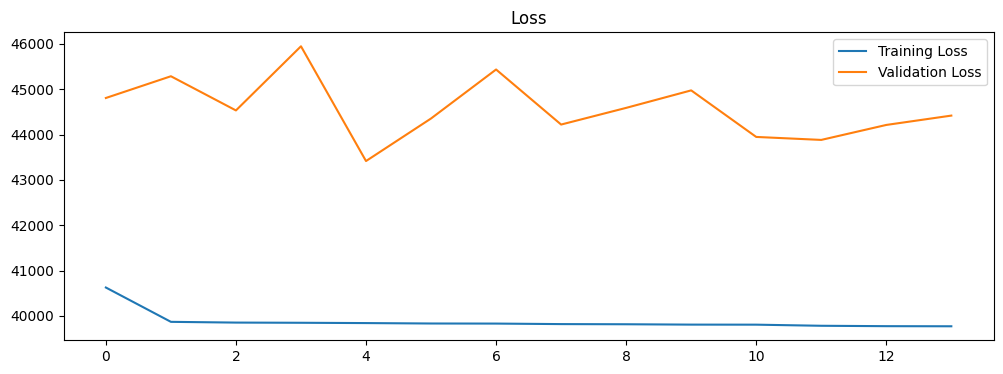

In [ ]:
plt.figure(figsize=(12, 4))
plt.plot(history.history['loss'][1:], label="Training Loss")
plt.plot(history.history['val_loss'][1:], label="Validation Loss")
plt.legend()
plt.title("Loss")
plt.show()

# SentimentAnalysis

In [ ]:
train_df = pd.read_csv('SentimentAnalysisTrain.csv', encoding='unicode_escape')
test_df = pd.read_csv('SentimentAnalysisTest.csv', encoding='unicode_escape')
train_df

,textID,text,selected_text,sentiment,Time of Tweet,Age of User,Country,Population -2020,Land Area (Km²),Density (P/Km²)
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,morning,0-20,Afghanistan,38928346,652860.0,60
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,noon,21-30,Albania,2877797,27400.0,105
2,088c60f138,my boss is bullying me...,bullying me,negative,night,31-45,Algeria,43851044,2381740.0,18
3,9642c003ef,what interview! leave me alone,leave me alone,negative,morning,46-60,Andorra,77265,470.0,164
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,noon,60-70,Angola,32866272,1246700.0,26
...,...,...,...,...,...,...,...,...,...,...
27476,4eac33d1c0,wish we could come see u on Denver husband l...,d lost,negative,night,31-45,Ghana,31072940,227540.0,137
27477,4f4c4fc327,I`ve wondered about rake to. The client has ...,", don`t force",negative,morning,46-60,Greece,10423054,128900.0,81
27478,f67aae2310,Yay good for both of you. Enjoy the break - y...,Yay good for both of you.,positive,noon,60-70,Grenada,112523,340.0,331
27479,ed167662a5,But it was worth it ****.,But it was worth it ****.,positive,night,70-100,Guatemala,17915568,107160.0,167


In [ ]:
train_df = train_df.dropna()
test_df = test_df.dropna()


In [ ]:
train_df['text'] = train_df['text'].apply(lambda x: x.lower())
test_df['text'] = test_df['text'].apply(lambda x: x.lower())
train_df['text'] = train_df['text'].apply((lambda x: re.sub('[^a-zA-z0-9\s]','',x)))
test_df['text'] = test_df['text'].apply((lambda x: re.sub('[^a-zA-z0-9\s]','',x)))

In [ ]:
train_texts = train_df['text'].tolist()
test_texts = test_df['text'].tolist()

train_labels = train_df['sentiment'].tolist()
test_labels = test_df['sentiment'].tolist()


In [ ]:
all_words = []
for s in train_texts + test_texts:
    all_words.append(s.split())

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_texts + test_texts)
word_index = tokenizer.word_index

X_train_seq = tokenizer.texts_to_sequences(train_texts)
X_train = pad_sequences(X_train_seq, padding='post')

max_length = X_train.shape[1]
X_test_seq = tokenizer.texts_to_sequences(test_texts)
X_test = pad_sequences(X_test_seq, maxlen=max_length, padding='post')

In [ ]:
word2vec_model = Word2Vec(sentences=all_words, vector_size=max_length, window=5, min_count=1, workers=4)

In [ ]:
y_train = pd.get_dummies(train_labels)
y_test = pd.get_dummies(test_labels)

In [ ]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((27480, 34), (27480, 3), (3534, 34), (3534, 3))

In [ ]:
embedding_dim = max_length
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
for word, i in word_index.items():
    if word in word2vec_model.wv:
        embedding_matrix[i] = word2vec_model.wv[word]

In [ ]:
model = Sequential()
model.add(Embedding(input_dim=len(word_index) + 1,
                    output_dim=embedding_dim,
                    weights=[embedding_matrix],
                    input_length=max_length,
                    trainable=False))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(3, activation='softmax'))
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 34, 34)            1055190   
                                                                 
 spatial_dropout1d_7 (Spati  (None, 34, 34)            0         
 alDropout1D)                                                    
                                                                 
 lstm_7 (LSTM)               (None, 100)               54000     
                                                                 
 dense_7 (Dense)             (None, 3)                 303       
                                                                 
Total params: 1109493 (4.23 MB)
Trainable params: 54303 (212.12 KB)
Non-trainable params: 1055190 (4.03 MB)
_________________________________________________________________


In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train,
          epochs=20,
          validation_split=0.15,
          batch_size=64,
          verbose=1)

Epoch 1/20
365/365 [==============================] - 29s 62ms/step - loss: 1.0260 - accuracy: 0.4705 - val_loss: 0.9721 - val_accuracy: 0.5197
Epoch 2/20
365/365 [==============================] - 23s 62ms/step - loss: 0.9811 - accuracy: 0.5148 - val_loss: 0.9232 - val_accuracy: 0.5665
Epoch 3/20
365/365 [==============================] - 24s 66ms/step - loss: 0.9670 - accuracy: 0.5278 - val_loss: 0.8993 - val_accuracy: 0.5832
Epoch 4/20
365/365 [==============================] - 24s 65ms/step - loss: 0.9494 - accuracy: 0.5435 - val_loss: 0.8986 - val_accuracy: 0.5752
Epoch 5/20
365/365 [==============================] - 26s 71ms/step - loss: 0.9421 - accuracy: 0.5497 - val_loss: 0.8891 - val_accuracy: 0.6002
Epoch 6/20
365/365 [==============================] - 42s 115ms/step - loss: 0.9275 - accuracy: 0.5620 - val_loss: 0.8739 - val_accuracy: 0.6041
Epoch 7/20
365/365 [==============================] - 29s 79ms/step - loss: 0.9198 - accuracy: 0.5656 - val_loss: 0.8494 - val_accuracy

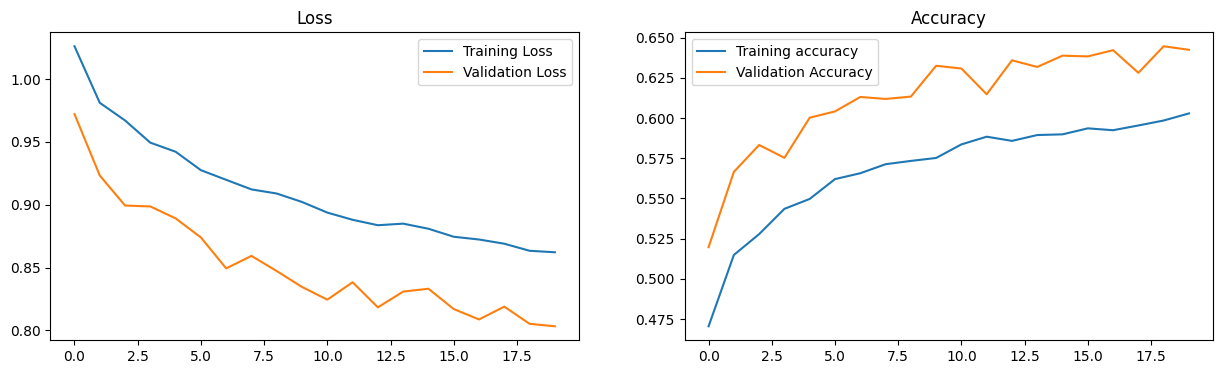

In [ ]:
plt.figure(figsize=(15, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label="Training Loss")
plt.plot(history.history['val_loss'], label="Validation Loss")
plt.legend()
plt.title("Loss")


plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label="Training accuracy")
plt.plot(history.history['val_accuracy'], label="Validation Accuracy")
plt.title("Accuracy")
plt.legend()
plt.show()

In [ ]:
train_acc = model.evaluate(X_train, y_train, verbose=0)[1]
test_acc = model.evaluate(X_test, y_test, verbose=0)[1]
print(f"Train Accuracy: {train_acc:.2f}")
print(f"Test Accuracy: {test_acc:.2f}")

Train Accuracy: 0.65
Test Accuracy: 0.64
